In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
samiulhaq45_final_alzheimer_dataset_path = kagglehub.dataset_download('samiulhaq45/final-alzheimer-dataset')

print('Data source import complete.')


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

print(tf.__version__)

Number of replicas: 1
2.15.0


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [224, 224]
EPOCHS = 30

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/final-alzheimer-dataset/output/Train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=32,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/final-alzheimer-dataset/output/Train",
    validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=32,
)

Found 9600 files belonging to 4 classes.
Using 7680 files for training.
Found 9600 files belonging to 4 classes.
Using 2880 files for validation.


In [ ]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

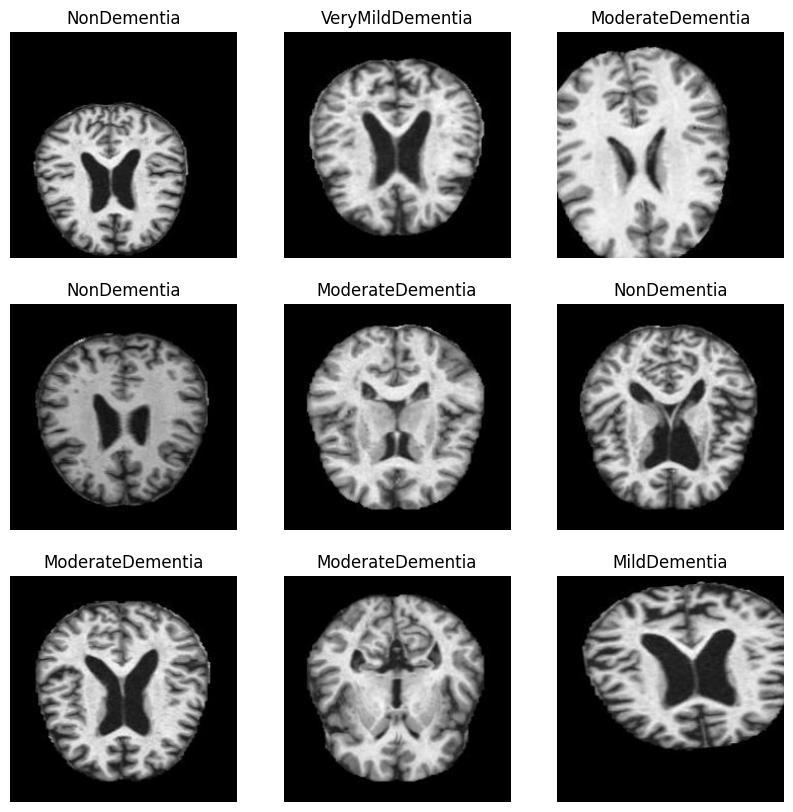

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [ ]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
import os

# Correct class names to match directory names
class_names = ['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'mildDemented']

NUM_IMAGES = []

base_path = "/kaggle/input/final-alzheimer-dataset/output/Train/"

# List directories at each level to verify
print("Base directory contents:", os.listdir(base_path))

for label in class_names:
    dir_name = base_path + label
    try:
        num_images = len([name for name in os.listdir(dir_name)])
        NUM_IMAGES.append(num_images)
        print(f"{label}: {num_images} images")
    except FileNotFoundError:
        print(f"Directory not found: {dir_name}")

print("Number of images per class:", NUM_IMAGES)


Base directory contents: ['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'mildDemented']
ModerateDemented: 2400 images
NonDemented: 2400 images
VeryMildDemented: 2400 images
mildDemented: 2400 images
Number of images per class: [2400, 2400, 2400, 2400]


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import pickle

# Define class names based on your dataset
class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

# Load the pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers to prevent them from being trained
for layer in base_model.layers:
    layer.trainable = False

# Print the model summary
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,212,740 (99.99 MB)

 Trainable params: 2,625,028 (10.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.000001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define the checkpoint callback to save only the best model based on validation accuracy
checkpoint_cb = ModelCheckpoint(
    filepath='/kaggle/working/RestNet50_best_Weights.weights.h5',  # The path where the model weights will be saved
    monitor='val_accuracy',  # Metric to monitor
    save_best_only=True,  # Only save the best model
    save_weights_only=True,  # Save only weights
    mode='max',  # Mode can be 'min', 'max', or 'auto'
    verbose=2  # Display messages
)

# Define the CSVLogger callback to save training history
csv_logger = CSVLogger('training_log.csv', separator=',', append=False)


In [ ]:
# Training the model (initial phase)
history = model.fit(train_ds, validation_data=val_ds, epochs=150, callbacks=[checkpoint_cb, csv_logger])

Epoch 1/150
  2/240 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - accuracy: 0.2188 - loss: 1.5421   

I0000 00:00:1733409021.853001     117 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1733409021.894874     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3826 - loss: 1.4062

W0000 00:00:1733409048.864364     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.56632, saving model to /kaggle/working/RestNet50_best_Weights.weights.h5
240/240 ━━━━━━━━━━━━━━━━━━━━ 51s 142ms/step - accuracy: 0.3829 - loss: 1.4058 - val_accuracy: 0.5663 - val_loss: 1.1003
Epoch 2/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5902 - loss: 1.0648
Epoch 2: val_accuracy improved from 0.56632 to 0.68299, saving model to /kaggle/working/RestNet50_best_Weights.weights.h5
240/240 ━━━━━━━━━━━━━━━━━━━━ 25s 106ms/step - accuracy: 0.5903 - loss: 1.0647 - val_accuracy: 0.6830 - val_loss: 0.9388
Epoch 3/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6914 - loss: 0.9220
Epoch 3: val_accuracy improved from 0.68299 to 0.73264, saving model to /kaggle/working/RestNet50_best_Weights.weights.h5
240/240 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - accuracy: 0.6915 - loss: 0.9219 - val_accuracy: 0.7326 - val_loss: 0.8320
Epoch 4/150
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7328 - loss: 0.8257
Epoch 4: val

In [ ]:
# Save the final model
model.save('/kaggle/working//RestNet50_final_model.h5')


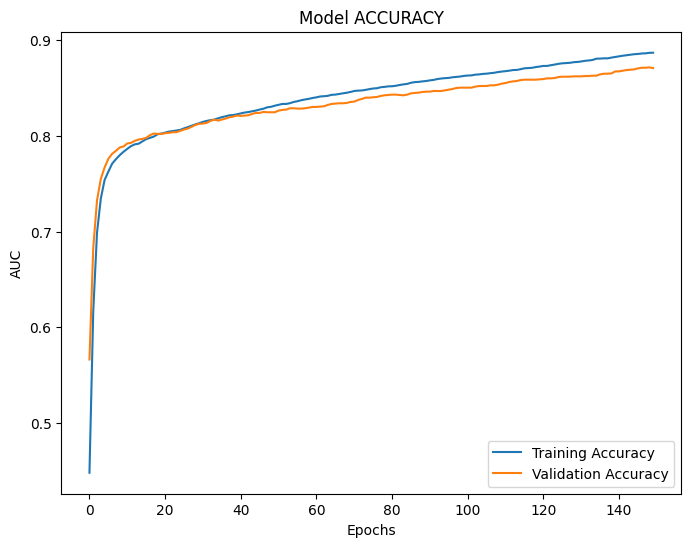

In [ ]:
import matplotlib.pyplot as plt

# Extract accuracy and loss for the first 150 epochs from the history object
acc = history.history['accuracy'][:150]      # Slicing the first 150 epochs
val_acc = history.history['val_accuracy'][:150]
loss = history.history['loss'][:150]
val_loss = history.history['val_loss'][:150]

# Define the range of epochs for the first 150 epochs
epochs_range = range(150)

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))  # Set the figure size for better quality
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('AUC')
# Save the figure for accuracy with high resolution (DPI) and first 150 epochs only
plt.savefig('/kaggle/working/model_accuracy_first_150_epochs.png', dpi=300, bbox_inches='tight')
plt.show()

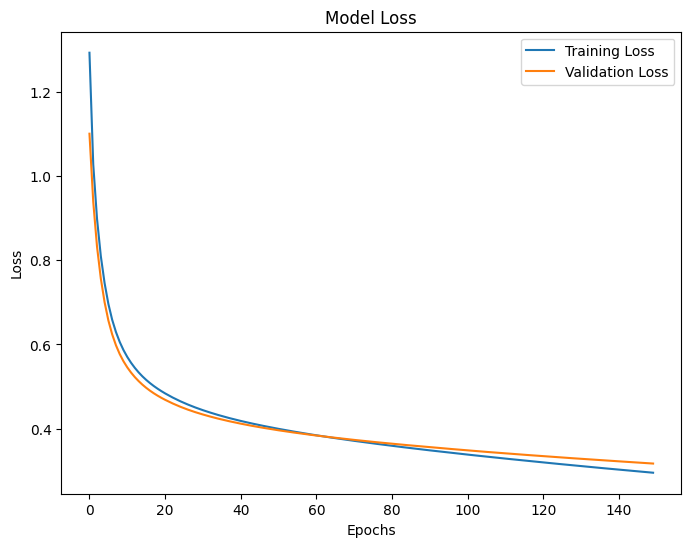

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(8, 6))  # Set the figure size for better quality
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Save the figure for loss with high resolution (DPI) and first 150 epochs only
plt.savefig('/kaggle/working/model_loss_first_150_epochs.png', dpi=300, bbox_inches='tight')
plt.show()

90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.8840 - loss: 0.3002
Test Accuracy: 87.08%
 3/90 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step

W0000 00:00:1733413341.738537     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step
                  precision    recall  f1-score   support

     NonDemented       1.00      0.98      0.99       719
VeryMildDemented       0.84      0.83      0.83       728
    MildDemented       0.74      0.83      0.78       728
ModerateDemented       0.94      0.84      0.89       705

        accuracy                           0.87      2880
       macro avg       0.88      0.87      0.87      2880
    weighted avg       0.88      0.87      0.87      2880



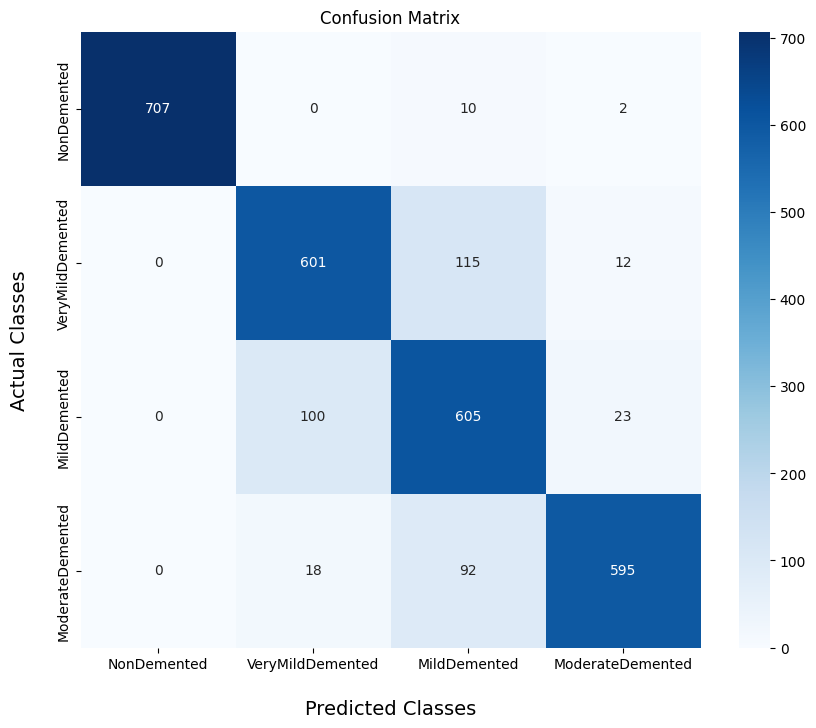

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(val_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Make predictions on the test dataset
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Print classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Classes', labelpad=20, fontsize=14)
plt.ylabel('Actual Classes', labelpad=20, fontsize=14)
plt.title('Confusion Matrix')
plt.show()
